In [9]:
from typing import TypedDict
import uuid

from langgraph.checkpoint.memory import InMemorySaver
from langgraph.constants import START
from langgraph.graph import StateGraph
from langgraph.types import interrupt, Command

class State(TypedDict):
    some_text: str

def human_node(state: State):

    print("> About to interrupt")
    value = interrupt( 
        {
            "text_to_revise": state["some_text"] 
        }
    )
    print("> Resumed, got:answer")
    return {
        "some_text": value 
    }


# Build the graph
graph_builder = StateGraph(State)
graph_builder.add_node("human_node", human_node)
graph_builder.add_edge(START, "human_node")

checkpointer = InMemorySaver() 

graph = graph_builder.compile(checkpointer=checkpointer)

# Pass a thread ID to the graph to run it.
config = {"configurable": {"thread_id": uuid.uuid4()}}

# Run the graph until the interrupt is hit.
result = graph.invoke({"some_text": " shaheerr"}, config=config) 

print(result['__interrupt__']) 
# > [
# >    Interrupt(
# >       value={'text_to_revise': 'original text'}, 
# >       resumable=True,
# >       ns=['human_node:6ce9e64f-edef-fe5d-f7dc-511fa9526960']
# >    )
# > ] 

print(graph.invoke(Command(resume="Syed Shaheer"), config=config)) 

# > {'some_text': 'Edited text'}

> About to interrupt
[Interrupt(value={'text_to_revise': ' shaheerr'}, resumable=True, ns=['human_node:caf00410-4708-6d68-bcd0-812e63e86f6d'])]
> About to interrupt
> Resumed, got:answer
{'some_text': 'Syed Shaheer'}


In [8]:
print(graph.invoke(Command(resume="Edited l"), config=config)) 


{'some_text': 'Edited text'}


In [7]:
print(graph.invoke(Command(resume="Edited j"), config=config)) 


{'some_text': 'Edited text'}


# approve or reject

In [2]:
from typing import Literal, TypedDict
import uuid

from langgraph.constants import START, END
from langgraph.graph import StateGraph
from langgraph.types import interrupt, Command
from langgraph.checkpoint.memory import MemorySaver

# Define the shared graph state
class State(TypedDict):
    llm_output: str
    decision: str

# Simulate an LLM output node
def generate_llm_output(state: State) -> State:

    print("i am from first")
    return {"llm_output": "This is the generated output."}

# Human approval node
def human_approval(state: State) -> Command[Literal["approved_path", "rejected_path"]]:
    decision = interrupt({
        "question": "Do you approve the following output?",
        "llm_output": state["llm_output"]
    })

    if decision == "approve":
        return Command(goto="approved_path", update={"decision": "approved"})
    else:
        return Command(goto="rejected_path", update={"decision": "rejected"})

# Next steps after approval
def approved_node(state: State) -> State:
    print("✅ Approved path taken.")
    return state

# Alternative path after rejection
def rejected_node(state: State) -> State:
    print("❌ Rejected path taken.")
    return state

# Build the graph
builder = StateGraph(State)
builder.add_node("generate_llm_output", generate_llm_output)
builder.add_node("human_approval", human_approval)
builder.add_node("approved_path", approved_node)
builder.add_node("rejected_path", rejected_node)

builder.set_entry_point("generate_llm_output")
builder.add_edge("generate_llm_output", "human_approval")
builder.add_edge("approved_path", END)
builder.add_edge("rejected_path", END)

checkpointer = MemorySaver()
graph = builder.compile(checkpointer=checkpointer)


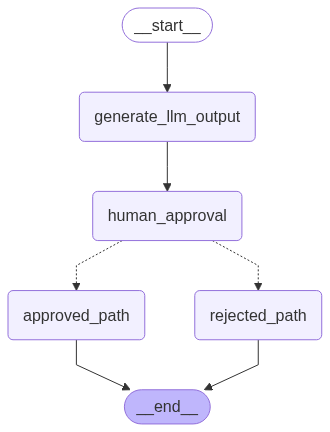

In [3]:
builder.compile()

In [4]:

# Run until interrupt
config = {"configurable": {"thread_id": uuid.uuid4()}}

result = graph.invoke({}, config=config)
print(result["__interrupt__"])



i am from first
[Interrupt(value={'question': 'Do you approve the following output?', 'llm_output': 'This is the generated output.'}, resumable=True, ns=['human_approval:baed16be-399e-0b5a-4254-b86029775d60'])]


In [5]:

# Output:
# Interrupt(value={'question': 'Do you approve the following output?', 'llm_output': 'This is the generated output.'}, ...)

# Simulate resuming with human input
# To test rejection, replace resume="approve" with resume="reject"
final_result = graph.invoke(Command(resume="approve"), config=config)
print(final_result)

✅ Approved path taken.
{'llm_output': 'This is the generated output.', 'decision': 'approved'}


# validation user input

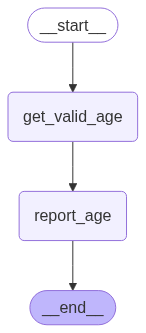

In [25]:
from typing import TypedDict
import uuid

from langgraph.constants import START, END
from langgraph.graph import StateGraph
from langgraph.types import interrupt, Command
from langgraph.checkpoint.memory import MemorySaver

# Define graph state
class State(TypedDict):
    age: int

# Node that asks for human input and validates it
def get_valid_age(state: State) -> State:
    prompt = "Please enter your age (must be a non-negative integer)."

    while True:
        user_input = interrupt(prompt)

        # Validate the input
        try:
            age = int(user_input)
            if age < 0:
                raise ValueError("Age must be non-negative.")
            break  # Valid input received
        except (ValueError, TypeError):
            prompt = f"'{user_input}' is not valid. Please enter a non-negative integer for age."

    return {"age": age}

# Node that uses the valid input
def report_age(state: State) -> State:
    print(f"✅ Human is {state['age']} years old.")
    return state

# Build the graph
builder = StateGraph(State)
builder.add_node("get_valid_age", get_valid_age)
builder.add_node("report_age", report_age)

builder.set_entry_point("get_valid_age")
builder.add_edge("get_valid_age", "report_age")
builder.add_edge("report_age", END)

# Create the graph with a memory checkpointer
checkpointer = MemorySaver()
graph = builder.compile(checkpointer=checkpointer)
builder.compile()

In [26]:

# Run the graph until the first interrupt
config = {"configurable": {"thread_id": uuid.uuid4()}}
result = graph.invoke({}, config=config)
print(result["__interrupt__"])  # First prompt: "Please enter your age..."


[Interrupt(value='Please enter your age (must be a non-negative integer).', resumable=True, ns=['get_valid_age:2fadf197-0232-72be-bffd-36d1dc3b5b1a'])]


In [28]:

# Simulate an invalid input (e.g., string instead of integer)
result = graph.invoke(Command(resume="not a number"), config=config)
print(result["__interrupt__"])  # Follow-up prompt with validation message


[Interrupt(value="'not a number' is not valid. Please enter a non-negative integer for age.", resumable=True, ns=['get_valid_age:2fadf197-0232-72be-bffd-36d1dc3b5b1a'])]


In [23]:

# Simulate a second invalid input (e.g., negative number)
result = graph.invoke(Command(resume="-10"), config=config)
print(result["__interrupt__"])  # Another retry


[Interrupt(value="'-10' is not valid. Please enter a non-negative integer for age.", resumable=True, ns=['get_valid_age:e79239f5-e4e7-6533-cbbb-4e4618c925ab'])]


In [24]:

# Provide valid input
final_result = graph.invoke(Command(resume="25"), config=config)
print(final_result)  # Should include the valid ag

✅ Human is 25 years old.
{'age': 25}


# add interrupt to tool

In [ ]:
from typing import Callable
from langchain_core.tools import BaseTool, tool as create_tool
from langchain_core.runnables import RunnableConfig
from langgraph.types import interrupt 
from langgraph.prebuilt.interrupt import HumanInterruptConfig, HumanInterrupt

def add_human_in_the_loop(
    tool: Callable | BaseTool,
    *,
    interrupt_config: HumanInterruptConfig = None,
) -> BaseTool:
    """Wrap a tool to support human-in-the-loop review.""" 
    if not isinstance(tool, BaseTool):
        tool = create_tool(tool)

    if interrupt_config is None:
        interrupt_config = {
            "allow_accept": True,
            "allow_edit": True,
            "allow_respond": True,
        }

    @create_tool(  
        tool.name,
        description=tool.description,
        args_schema=tool.args_schema
    )
    def call_tool_with_interrupt(config: RunnableConfig, **tool_input):
        request: HumanInterrupt = {
            "action_request": {
                "action": tool.name,
                "args": tool_input
            },
            "config": interrupt_config,
            "description": "Please review the tool call"
        }
        response = interrupt([request])[0]  
        # approve the tool call
        if response["type"] == "accept":
            tool_response = tool.invoke(tool_input, config)
        # update tool call args
        elif response["type"] == "edit":
            tool_input = response["args"]["args"]
            tool_response = tool.invoke(tool_input, config)
        # respond to the LLM with user feedback
        elif response["type"] == "response":
            user_feedback = response["args"]
            tool_response = user_feedback
        else:
            raise ValueError(f"Unsupported interrupt response type: {response['type']}")

        return tool_response

    return call_tool_with_interrupt

# Using multiple interrupts

In [6]:
import os
import uuid
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.types import interrupt, Command
from langgraph.checkpoint.memory import InMemorySaver
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage

# Load Google Gemini API key
Talk_llm = os.getenv("GEMINI_API_KEYY")
model = ChatGoogleGenerativeAI(model="gemini-1.5-flash", google_api_key=Talk_llm)

class State(TypedDict):
    conversation: list[dict]  # Stores conversation history as list of message dictionaries
    continue_chat: bool       # Flag to continue or stop conversation

def multi_turn_node(state: State):
    # Initialize conversation list if not present
    conversation = state.get("conversation", [])
    continue_chat = state.get("continue_chat", True)

    if not continue_chat:
        print("Conversation ended.")
        return {"conversation": conversation, "continue_chat": False}

    # Prepare messages for model
    formatted_messages = []
    
    # Add system context if it's the first turn
    if not conversation:
        formatted_messages.append(SystemMessage(content="You are a helpful AI assistant. Engage in a friendly conversation."))

    # Convert conversation history to message objects
    for msg in conversation:
        if msg['role'] == 'human':
            formatted_messages.append(HumanMessage(content=msg['content']))
        elif msg['role'] == 'ai':
            formatted_messages.append(AIMessage(content=msg['content']))

    # Invoke the model with conversation history
    try:
        ai_response = model.invoke(formatted_messages)
        
        # Append AI response to conversation
        conversation.append({
            'role': 'ai', 
            'content': ai_response.content
        })
        
        # Print AI's response
        print("AI:", ai_response.content)

    except Exception as e:
        print(f"Error invoking model: {e}")
        continue_chat = False
        return {"conversation": conversation, "continue_chat": continue_chat}

    # Pause and wait for user input
    prompt = "Your turn (type 'exit' to stop):"
    user_input = interrupt(prompt)

    # Append user input to conversation history
    conversation.append({
        'role': 'human', 
        'content': user_input
    })

    # Check for exit condition
    if user_input.strip().lower() == "exit":
        continue_chat = False
        print("User requested to end the conversation.")

    return {"conversation": conversation, "continue_chat": continue_chat}

# Build the graph
builder = StateGraph(State)
builder.add_node("multi_turn_node", multi_turn_node)
builder.add_edge(START, "multi_turn_node")
builder.add_edge("multi_turn_node", "multi_turn_node")  # Loop back for multi-turn
builder.add_edge("multi_turn_node", END)  # End when continue_chat is False

# Compile with a checkpointer to save state
checkpointer = InMemorySaver()
graph = builder.compile(checkpointer=checkpointer)

# Config with unique thread_id for session
config = {"configurable": {"thread_id": uuid.uuid4()}}

# Initial state
initial_state = {"conversation": [], "continue_chat": True}

# Run the graph until first interrupt (user input)
for event in graph.stream(initial_state, config, stream_mode="updates"):
    print(event)
    if "__interrupt__" in event:
        break

# Simulate user input and resume multiple times
user_inputs = [
    "Hello, i am bob", 
    "what is my name", 
    "exit"
]

for user_text in user_inputs:
    print(f"\nResuming with user input: {user_text}")
    for event


SyntaxError: invalid syntax (631294677.py, line 108)